In [69]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('CFPB_Complaints_FL.csv')

# Clean the dataset
def clean_dataset(df):
    # Fill NaN values with 0
    df.fillna(0, inplace=True)
    
    # Drop rows where all columns are blank
    df.dropna(how='all', inplace=True)
    
    # Strip any leading or trailing whitespace from column names and values
    df.columns = df.columns.str.strip()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.strip()
    
    # Handle specific formatting issues (e.g., ZIP code consistency)
    if 'ZIP code' in df.columns:
        df['ZIP code'] = df['ZIP code'].astype(str).str.zfill(5)
    
    # Drop duplicate rows if any
    df.drop_duplicates(inplace=True)
    
    return df

# Clean "Consumer complaint narrative"
# Text Cleaning Function with Exclusion Patterns
def clean_text_column(df, column_name):
    """
    Clean the text column by removing special characters, lowering case, 
    removing stopwords, and excluding specific patterns.
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    exclude_patterns = {
        "xxxx", "xxxx xxxx", "xxxxxxxx", "xxxx xxxx xxxx", 
        "xxxx xxxx xxxx xxxx", "i", "u", "everything", 
        "nothing", "anything", "someone"
    }
    
    def process_text(text):
        # Remove special characters and lowercase the text
        text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
        words = word_tokenize(text)  # Tokenize text
        # Filter out stopwords, exclude patterns, and lemmatize
        words = [
            lemmatizer.lemmatize(word) 
            for word in words 
            if word not in stop_words and word not in exclude_patterns
        ]
        return ' '.join(words)  # Join back into a single string
    
    # Apply processing to the column
    df[column_name] = df[column_name].apply(process_text)
    return df
    
# Apply cleaning steps
data = clean_dataset(data)
data = clean_text_column(data, 'Consumer complaint narrative')
data = add_sentiment_scores(data, 'Consumer complaint narrative')

# Save the cleaned dataset to a new file
output_file = 'Cleaned_CFPB_Complaints_FL.csv'
data.to_csv(output_file, index=False)

print(f"Cleaned dataset saved to: {output_file}")

Cleaned dataset saved to: Cleaned_CFPB_Complaints_FL.csv


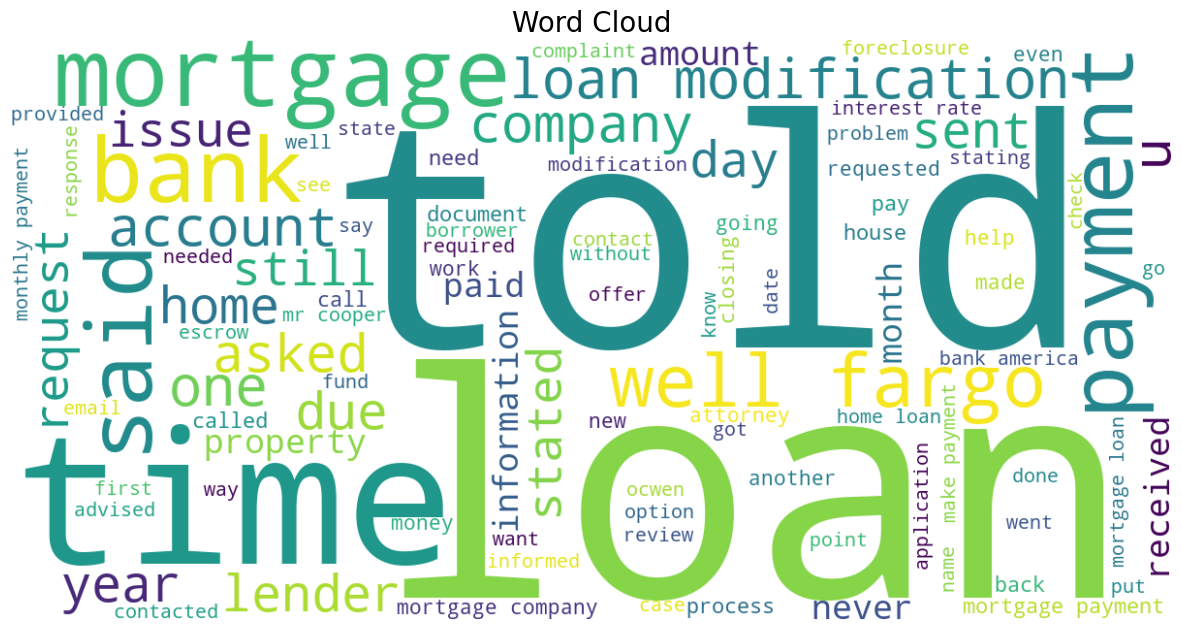

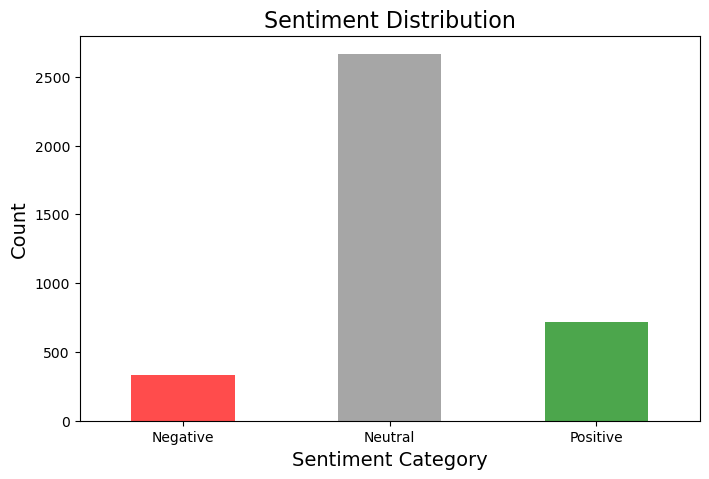

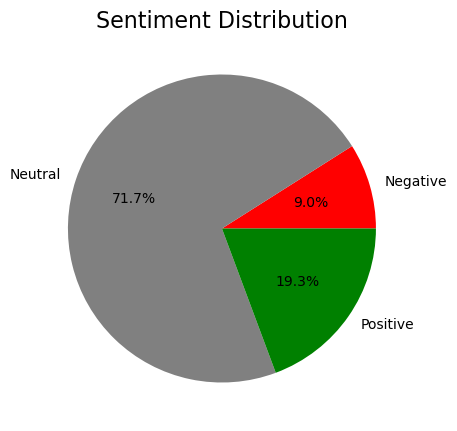

In [71]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Sentiment Analysis
def add_sentiment_scores(df, column_name, sentiment_column_name='Sentiment'):
    """
    Add sentiment scores to the dataset based on the text column.
    """
    df[sentiment_column_name] = df[column_name].apply(
        lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0
    )
    return df

# Generate Word Cloud
def generate_word_cloud(df, column_name, title='Word Cloud'):
    """
    Generate a word cloud from the specified text column.
    """
    text = ' '.join(df[column_name].dropna().astype(str))
    wordcloud = WordCloud(
        width=1200, height=600, background_color='white', colormap='viridis', max_words=100
    ).generate(text)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Extract Key Phrases
def extract_key_phrases_in_chunks(df, column_name, num_phrases=10):
    """
    Extract the most common noun phrases from a text column, excluding specific patterns.
    """
    phrases = []
    exclude_patterns = {"xxxx", "xxxx xxxx", "xxxxxxxx", "i", "u"}
    
    for text in df[column_name].dropna().astype(str):
        doc = nlp(text)
        phrases.extend([
            chunk.text.strip() 
            for chunk in doc.noun_chunks 
            if chunk.text.strip().lower() not in exclude_patterns
        ])
    
    common_phrases = Counter(phrases).most_common(num_phrases)
    print("Most Common Key Phrases:")
    for phrase, count in common_phrases:
        print(f"{phrase}: {count}")

# Sentiment Visualizations
def plot_sentiment_distribution(df, sentiment_column):
    """
    Plot the sentiment distribution as a bar chart and pie chart.
    """
    categories = ['Negative', 'Neutral', 'Positive']
    df['Sentiment Category'] = pd.cut(
        df[sentiment_column], bins=[-1, -0.1, 0.1, 1], labels=categories
    )
    sentiment_counts = df['Sentiment Category'].value_counts().reindex(categories)
    
    # Bar Chart
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind='bar', color=['red', 'gray', 'green'], alpha=0.7)
    plt.title('Sentiment Distribution', fontsize=16)
    plt.xlabel('Sentiment Category', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=0)
    plt.show()
    
    # Pie Chart
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['red', 'gray', 'green'])
    plt.title('Sentiment Distribution', fontsize=16)
    plt.ylabel('')
    plt.show()

# Main Script
data = pd.read_csv('CFPB_Complaints_FL.csv')
data = clean_dataset(data)
data = clean_text_column(data, 'Consumer complaint narrative')
data = add_sentiment_scores(data, 'Consumer complaint narrative')

# Generate visualizations and perform analyses
generate_word_cloud(data, 'Consumer complaint narrative')
plot_sentiment_distribution(data, 'Sentiment')

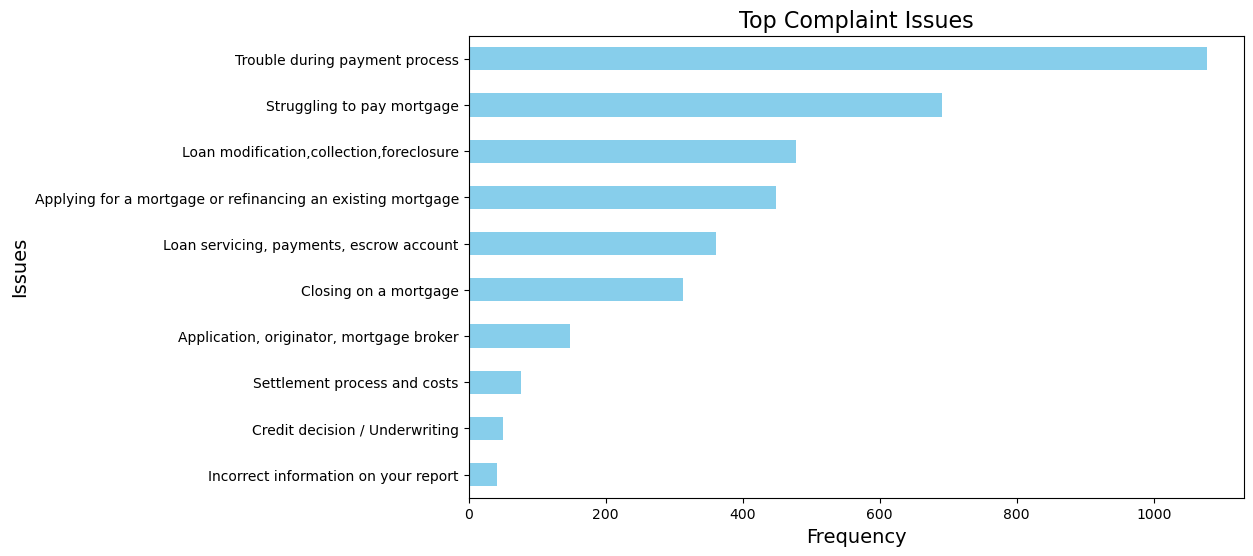

In [73]:
def group_by_issue(df, issue_column, top_n=10):
    issue_counts = df[issue_column].value_counts().head(top_n)

    plt.figure(figsize=(10, 6))
    issue_counts.plot(kind='barh', color='skyblue')
    plt.title('Top Complaint Issues', fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Issues', fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()

# Example Usage
group_by_issue(data, 'Issue', top_n=10)


In [75]:
import spacy
from collections import Counter

# Load spaCy's English language model
nlp = spacy.load("en_core_web_sm")

def extract_key_phrases_in_chunks(df, column_name, num_phrases=10):
    """
    Extract the most common noun phrases from a text column in a dataframe,
    excluding placeholder words such as 'xxxx'.

    Args:
        df (pd.DataFrame): The dataframe containing the text data.
        column_name (str): The name of the column with text data.
        num_phrases (int): Number of most common phrases to extract.

    Returns:
        None: Prints the most common phrases and their counts.
    """
    # Initialize an empty list to store all noun phrases
    phrases = []

    # Define a set of placeholder patterns to exclude
    exclude_patterns = {"xxxx", "xxxx xxxx", "xxxxxxxx", "xxxx xxxx xxxx", "xxxx xxxx xxxx xxxx", "i", "u", "everything", "nothing", "anything", "someone"}

    # Process each row of text individually
    for text in df[column_name].dropna().astype(str):
        doc = nlp(text)  # Process text chunk
        # Extract noun phrases and filter out placeholders
        phrases.extend([
            chunk.text.strip() 
            for chunk in doc.noun_chunks 
            if chunk.text.strip().lower() not in exclude_patterns
        ])

    # Count the most common phrases
    common_phrases = Counter(phrases).most_common(num_phrases)

    # Display the results
    print("Most Common Key Phrases:")
    for phrase, count in common_phrases:
        print(f"{phrase}: {count}")

# Example Usage
extract_key_phrases_in_chunks(data, 'Consumer complaint narrative', num_phrases=15)

Most Common Key Phrases:
payment: 1707
loan: 891
letter: 544
email: 488
money: 485
home: 476
mortgage: 430
fargo: 394
document: 394
account: 388
month: 382
information: 376
time: 372
help: 365
call: 332


In [77]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def perform_topic_modeling_with_labels(df, column_name, num_topics=5, num_words=10):
    """
    Perform topic modeling on the text column and assign descriptive labels to topics.

    Args:
        df (pd.DataFrame): The dataframe containing the text data.
        column_name (str): The name of the text column.
        num_topics (int): Number of topics to extract.
        num_words (int): Number of words to display per topic.

    Returns:
        None: Prints the topics, their top words, and descriptive labels.
    """
    # Vectorize the text
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    text_matrix = vectorizer.fit_transform(df[column_name].dropna().astype(str))
    
    # Apply LDA
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(text_matrix)
    
    # Get feature names
    words = vectorizer.get_feature_names_out()

    # Descriptive labels for topics (to be assigned manually)
    topic_labels = [
        "Loan and Mortgage Issues",
        "Billing and Charges Complaints",
        "Customer Service Problems",
        "Account Access and Fraud",
        "Refund and Payment Issues"
    ]

    # Display topics with labels
    for idx, topic in enumerate(lda.components_):
        print(f"Topic {idx + 1}: {topic_labels[idx]}")
        top_words = " ".join([words[i] for i in topic.argsort()[-num_words:][::-1]])
        print(f"Top Words: {top_words}")
        print()

# Example Usage
perform_topic_modeling_with_labels(data, 'Consumer complaint narrative', num_topics=5)

Topic 1: Loan and Mortgage Issues
Top Words: loan home mortgage payment modification year time month help told

Topic 2: Billing and Charges Complaints
Top Words: payment mortgage insurance account loan escrow month company home received

Topic 3: Customer Service Problems
Top Words: mortgage loan fraud mr servicing note payment consumer borrower cooper

Topic 4: Account Access and Fraud
Top Words: loan closing home rate mortgage credit day lender email appraisal

Topic 5: Refund and Payment Issues
Top Words: bank modification document loan received letter fargo sent home time



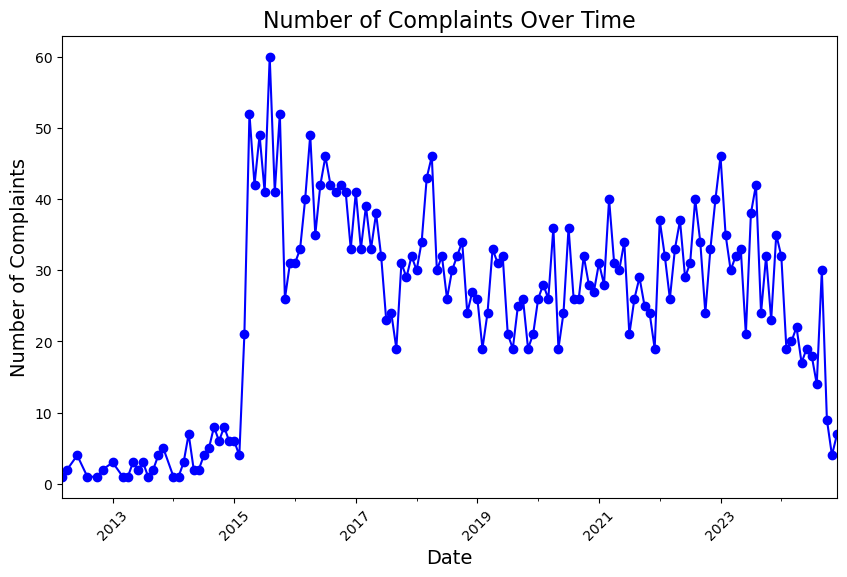

In [79]:
def complaints_over_time(df, date_column, text_column):
    df[date_column] = pd.to_datetime(df[date_column])
    complaints_timeline = df.groupby(df[date_column].dt.to_period('M'))[text_column].count()

    plt.figure(figsize=(10, 6))
    complaints_timeline.plot(marker='o', color='blue')
    plt.title('Number of Complaints Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Number of Complaints', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

# Example Usage
complaints_over_time(data, 'Date received', 'Consumer complaint narrative')
